In [28]:
import numpy
import pandas
from numpy import matrix
from pandas import DataFrame
import matplotlib.pyplot as pyplot


%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [29]:
# This class just holds the similitude matrixes used by
# my invented Kernel function
class StoreSimilitudeMatrixes(object):
    
               # Mon, Tue, Wed, Thu, Fri, Sat, Sun
    Days =  [[1, 0.5, 0.25, 0, 0, 0.25, 0.5], # Mon
             [0.5, 1, 0.5, 0.25, 0, 0, 0.25], # Tue 
             [0.25, 0.5, 1, 0.5, 0.25, 0, 0], # Wed
             [0, 0.25, 0.5, 1, 0.5, 0.25, 0], # Thu
             [0, 0, 0.25, 0.5, 1, 0.5, 0.25], # Fri
             [0.25, 0, 0, 0.25, 0.5, 1, 0.5], # Sat
             [0.5, 0.25, 0, 0, 0.25, 0.5, 1]] # Sun
    
    

In [30]:
# This class is the Kernel Matrix of the Subset Of Regressors 
# Algorithm. The class contains the different sections of the matrix. 
class KernelMatrix(object):
    
    
    def __init__(self, setN, subsetM):
        self.Submatrix_K_M_M = self.Calculate_Matrix_K_M_M(subsetM)
        self.Submatrix_K_M_N = self.Calculate_Matrix_K_M_N(subsetM, setN)
        self.Submatrix_K_N_M = self.Calculate_Matrix_K_N_M(setN, subsetM)
        return
    
    
    def Calculate_Matrix_K_M_M(self, subsetM):
        submatrix_K_M_M = numpy.empty(shape=[len(subsetM), len(subsetM)])
        for row in range(len(subsetM)):
            for col in range(len(subsetM)):
                submatrix_K_M_M[row,col] = self.K(subsetM.iloc[row], subsetM.iloc[col])
        return submatrix_K_M_M
    
    
    def Calculate_Matrix_K_M_N(self, subsetM, setN):
        submatrix_K_M_N = numpy.empty(shape=[len(subsetM), len(setN)])
        for row in range(len(subsetM)):
            for col in range(len(setN)):
                submatrix_K_M_N[row,col] = self.K(subsetM.iloc[row], setN.iloc[col])
        return submatrix_K_M_N
    
    
    def Calculate_Matrix_K_N_M(self, setN, subsetM):
        submatrix_K_N_M = numpy.empty(shape=[len(setN), len(subsetM)])
        for row in range(len(setN)):
            for col in range(len(subsetM)):
                submatrix_K_N_M[row,col] = self.K(setN.iloc[row], subsetM.iloc[col])
        return submatrix_K_N_M
    
    
    def Calculate_Vector_K_t_M(self, testVector, subsetM):
        submatrix_K_t_M = numpy.empty(shape=[1, len(subsetM)])
        for col in range(len(subsetM)):
            submatrix_K_t_M[0,col] = self.K(testVector, subsetM.iloc[col])
        return submatrix_K_t_M
    
    
    # Construction of my invented Kernel function
    def K(self, dataEntryI, dataEntryJ):
        indexFixer = 1
        day1 = numpy.asscalar(dataEntryI.DayOfWeek) - indexFixer
        day2 = numpy.asscalar(dataEntryJ.DayOfWeek) - indexFixer
        distance = StoreSimilitudeMatrixes.Days[day1][day2]
        return distance
        
        

In [31]:
class SubsetOfRegressors(object):
    
    
    def __init__(self, trainingFeatures, trainingLabels):
        self.SetN = trainingFeatures
        self.SubsetM = self.Select_SubsetM(self.SetN)
        self.KernelMatrix = KernelMatrix(self.SetN, self.SubsetM)
        self.Alpha = self.Calculate_Alpha(self.KernelMatrix, trainingLabels)
        return
    
    
    # Implementation of a simple selection algorithm to select the subset m
    def Select_SubsetM(self, setN):
        lenght = 100
        subsetM = self.SetN.iloc[numpy.random.permutation(len(self.SetN))][0:lenght]
        return subsetM
    
    
    # First Part implementation of the subset of regressors algorithm.
    # I divided the equation in two functions because one part does not 
    # change, so this part of the equation can be saved in memory.
    def Calculate_Alpha(self, kernelMatrix, trainingLabels):
        matrix_K_M_M = kernelMatrix.Submatrix_K_M_M
        matrix_K_M_N = kernelMatrix.Submatrix_K_M_N
        matrix_K_N_M = kernelMatrix.Submatrix_K_N_M
        sigmaSquare = 1
        columnVector_Y = trainingLabels
        
        dotProduct = numpy.dot(matrix_K_M_N, matrix_K_N_M) 
        matrixMultiplication = (sigmaSquare * matrix_K_M_M)
        addition = dotProduct + matrixMultiplication
        additionInv = numpy.linalg.pinv(addition)
        secondDotProduct = numpy.dot(matrix_K_M_N, columnVector_Y)
        alpha = numpy.dot(additionInv, secondDotProduct)
        return alpha
        
      
    # Second Part of the implementation of the subset of regressors algorithm.
    # This is the part that has to be calculated from scratch with every new point
    def Calculate_Mu_Prime(self, testPoint):
        rowVector_K_t_M = self.KernelMatrix.Calculate_Vector_K_t_M(testPoint, self.SubsetM)
        muPrime = numpy.dot(rowVector_K_t_M, self.Alpha)
        muPrime = numpy.asscalar(muPrime)
        return muPrime
        
        

In [32]:
# This class just shows that the Subset of Regressors algorithm
# is used inside a classifier, but the classifier is just a practical
# implementation of the algorithm.
class StoreClassifier(object):
    
    
    def __init__(self, trainingFeatures, trainingLabels):
        self.Algorithm = SubsetOfRegressors(trainingFeatures, trainingLabels)
        return
        
        
    def Predict(self, testPoint):
        muPrime = self.Algorithm.Calculate_Mu_Prime(testPoint)
        return muPrime
    
    

In [33]:
# This class contains the logic specific to this homework
class Main(object):
    
    
    def __init__(self):
        testData = pandas.read_csv( 'store_test.csv' )
        trainingData = pandas.read_csv( 'store_train.csv' )
        
        testData = testData.iloc[numpy.random.permutation(len(testData))] #[0:1000]
        trainingData = trainingData.iloc[np.random.permutation(len(trainingData))][0:1000]
        
        self.TrainingLabels = trainingData['Sales']
        self.TrainingFeatures = trainingData.drop(['Sales'], axis=1) 
        
        self.TestFeatures = testData
        
        self.Classifier = StoreClassifier(self.TrainingFeatures, self.TrainingLabels)
        
        self.Predictions = list()
        return
        
    
    def PredictTestFeatures(self):
        for index in range(len(self.TestFeatures)):
            self.Predictions.append(self.Classifier.Predict(self.TestFeatures.iloc[index]))
        
    
        
    def MakeKaggleSubmittionFile(self):
        sfile = open( 'kaggleSubmittionFile.csv', 'wb' )
        sfile.write( '"Id","Sales"\n' )
        
        for index in range( 0, len(self.Predictions) ):
            id = index + 1
            prediction = self.Predictions[index]
            
            sfile.write( '%d,%.2f\n' % ( id, prediction ) )  # add one for one-based indexing
        sfile.close()
    
    
    # Displays the kernel matrix
    def Print_Matrix_K_M_M(self):
        matrix_K_M_M = self.Classifier.Algorithm.KernelMatrix.Submatrix_K_M_M
        matrix_length = matrix_K_M_M.shape[0]
        matrix_range = range(0,matrix_length)
        figure = plt.figure()
        figure.set_size_inches(20, 20, forward = True)
        subplot = figure.add_subplot(111)
        matplot = subplot.matshow(matrix_K_M_M)
        figure.colorbar(matplot)
        subplot.set_title("matrix Kmm")
        return
        
    
    

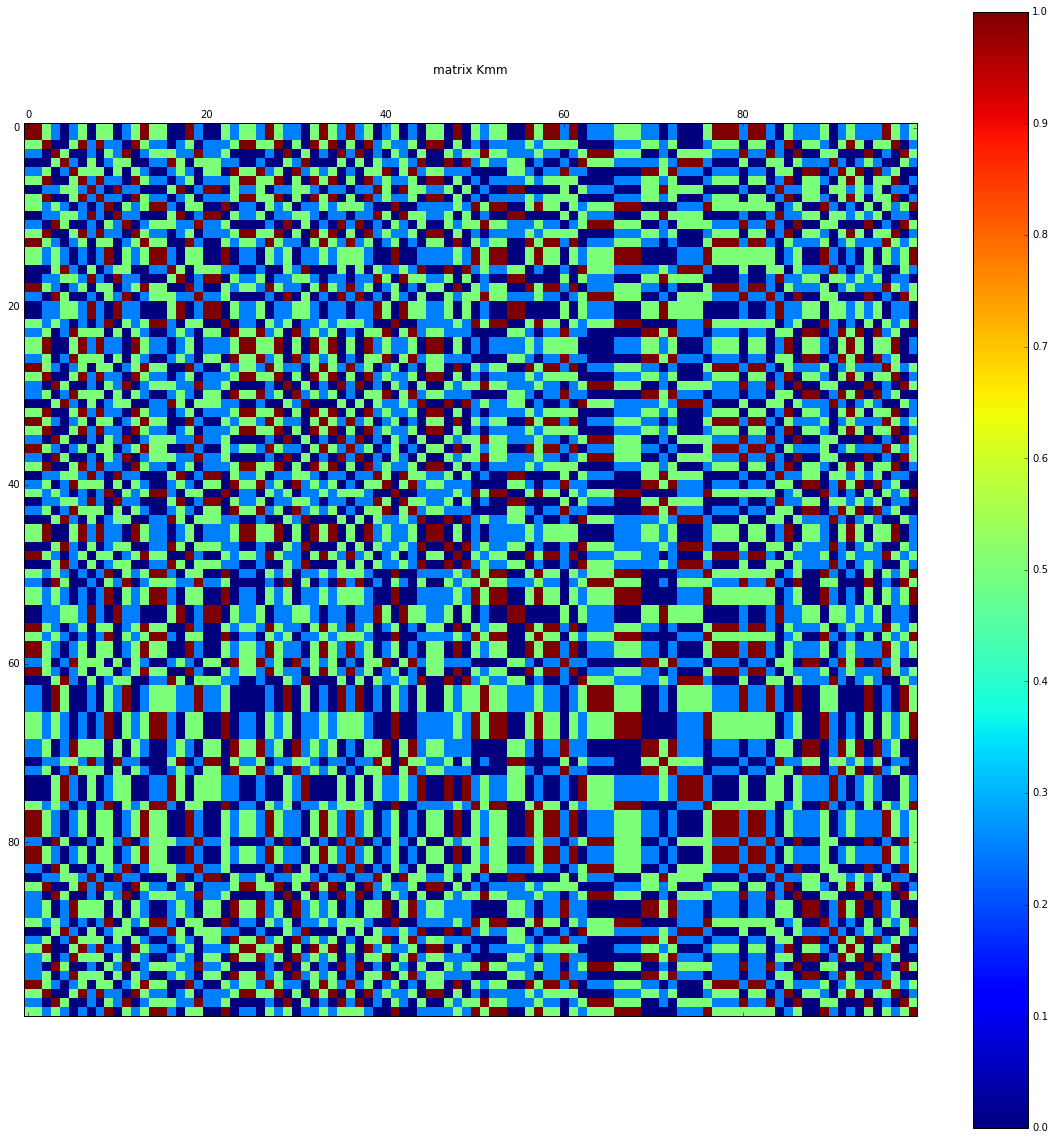

In [34]:
main = Main()
main.PredictTestFeatures()
main.MakeKaggleSubmittionFile()
main.Print_Matrix_K_M_M()



######################### From the Kaggle Competition #########################
# Accuracy was 0.60745 Root Mean Square Percentage Error

